# Exploring and predicting Airbnb prices in Austin, Texas
Author: Daniel Cummings   
Email: daniel.j.cummings@me.com   
Date: 9/14/18   
  

### Overview

- From a map perspective, what is the average price per zipcode? Price per person?
- Price based on 'accomomates'
- Price based on 'number of reviews' and 'rating' 
Dataset source: http://insideairbnb.com/get-the-data.html   
- listings.csv - Detailed Listings data for Austin    


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Pandas warning messages
pd.options.mode.chained_assignment = None  # default='warn'

# Plot options
sns.palplot(sns.color_palette('deep'))
%matplotlib inline

***
## Gather Data

In [2]:
# Import csv into pandas DataFrame
df_listings = pd.read_csv('listings.csv')

C:\Users\djcummin\anaconda3\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


***
## Assess Data

In [3]:
# Examine features in DataFrame to determine what is needed
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11316 entries, 0 to 11315
Data columns (total 96 columns):
id                                  11316 non-null int64
listing_url                         11316 non-null object
scrape_id                           11316 non-null int64
last_scraped                        11316 non-null object
name                                11315 non-null object
summary                             10989 non-null object
space                               8124 non-null object
description                         11267 non-null object
experiences_offered                 11316 non-null object
neighborhood_overview               6818 non-null object
notes                               4893 non-null object
transit                             6801 non-null object
access                              7168 non-null object
interaction                         6924 non-null object
house_rules                         7469 non-null object
thumbnail_url                 

I want to focus on rental price and what features correlate to price. Therefore, I'm choose property size, ratings, and location related features since they intuitively seem like they would be the most relevant. 

In [4]:
columns_list = ['room_type', 'price', 'accommodates', 'bathrooms', 'bedrooms',  
                'host_is_superhost', 'neighbourhood_cleansed', 'number_of_reviews', 
                'review_scores_rating', 'minimum_nights', 'listing_url']

df = df_listings[columns_list]

In [5]:
df.head()

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,listing_url
0,Entire home/apt,$200.00,4,2.0,2.0,t,78702,22,92.0,2,https://www.airbnb.com/rooms/2265
1,Private room,$125.00,2,1.0,1.0,t,78702,9,91.0,2,https://www.airbnb.com/rooms/5245
2,Entire home/apt,$95.00,3,1.0,1.0,f,78702,441,96.0,2,https://www.airbnb.com/rooms/5456
3,Private room,$40.00,2,1.0,1.0,t,78729,231,98.0,1,https://www.airbnb.com/rooms/5769
4,Entire home/apt,$99.00,2,1.0,NaN,f,78704,75,99.0,3,https://www.airbnb.com/rooms/6413


In [6]:
df.describe()

,accommodates,bathrooms,bedrooms,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights
count,11316.000000,11285.000000,11311.000000,11316.000000,11316.000000,8254.000000,11316.000000
mean,4.511046,1.531635,1.777120,78721.957759,21.499116,96.234795,2.686108
std,2.934995,0.846736,1.222437,20.564327,45.642218,7.021552,8.395783
min,1.000000,0.000000,0.000000,78701.000000,0.000000,20.000000,1.000000
25%,2.000000,1.000000,1.000000,78704.000000,0.000000,95.000000,1.000000
50%,4.000000,1.000000,1.000000,78714.500000,4.000000,99.000000,2.000000
75%,6.000000,2.000000,2.000000,78744.000000,21.000000,100.000000,2.000000
max,24.000000,13.500000,17.000000,78759.000000,645.000000,100.000000,365.000000


Noting for cleanup:
- Price needs to be converted to float
- Missing NaN values need data imputed or rows removed
- `neighbourhood_cleansed` (ZIP code) needs to be converted from int
- Categorical columns need to be converted to dummy variables (get_dummies)

***
## Clean

In [7]:
# Convert price to from currency to float
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].astype(float)

print("Dataset has {} row entries.".format(df.shape[0]))

Dataset has 11316 row entries.


In [8]:
# Verify price type is float
df.price.head()

0    200.0
1    125.0
2     95.0
3     40.0
4     99.0
Name: price, dtype: float64

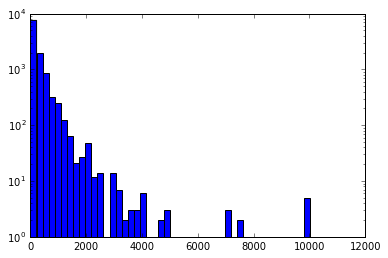

In [9]:
# What are the distribution of rental prices
fig, ax = plt.subplots()
ax.hist(df['price'], bins=50)
ax.set_yscale("log", nonposy='clip')
plt.show();

There are some oddly high prices (> $2000) that I want to examine. However, if the rental is a large proporty it would not be fair to discriminate based on price alone. I'll look at price per person (price / accommodates) to look for outliers. 

In [10]:
df['price_per_person'] = df['price']/df['accommodates']

df['price_per_person'].value_counts().sort_index(ascending=False).head(10)

5000.000000    1
3000.000000    1
1750.000000    1
1500.000000    1
1250.000000    1
1090.000000    1
1000.000000    3
937.500000     1
875.000000     1
833.333333     2
Name: price_per_person, dtype: int64

In [11]:
df.loc[df['price_per_person'] > 1000.00]

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,listing_url,price_per_person
626,Private room,7000.0,4,1.0,1.0,f,78749,2,80.0,3,https://www.airbnb.com/rooms/925980,1750.0
4186,Entire home/apt,3000.0,1,NaN,NaN,f,78746,0,NaN,1,https://www.airbnb.com/rooms/11479152,3000.0
4200,Entire home/apt,2500.0,2,1.0,1.0,f,78701,0,NaN,1,https://www.airbnb.com/rooms/11493969,1250.0
4246,Private room,3000.0,2,1.5,1.0,t,78744,9,100.0,1,https://www.airbnb.com/rooms/11548720,1500.0
6454,Private room,10000.0,2,1.0,1.0,f,78723,0,NaN,1,https://www.airbnb.com/rooms/17607193,5000.0
9047,Entire home/apt,10900.0,10,3.0,4.0,t,78704,1,100.0,20,https://www.airbnb.com/rooms/22765762,1090.0


Upon reviewing the url listings, the houses listed as with extreme prices looked like automated (or unmaintained) listings with little to no reviews with some being incorrectly priced at the time of the source data scrape. I'm opting to remove them from this analysis since they don't pass my common sense as a consumer. However, it would be intersting to examine other popular cities to see if they had similar outliers. 

In [12]:
# remove rows with > $1000 per person
df = df.loc[df['price_per_person'] <= 1000.00]

# verify removal
df['price_per_person'].value_counts().sort_index(ascending=False).head()

1000.000000    3
937.500000     1
875.000000     1
833.333333     2
800.000000     1
Name: price_per_person, dtype: int64

In [13]:
df.describe()

,price,accommodates,bathrooms,bedrooms,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,price_per_person
count,11310.000000,11310.000000,11280.000000,11306.000000,11310.000000,11310.000000,8251.000000,11310.000000,11310.000000
mean,271.384527,4.511583,1.531649,1.777198,78721.954642,21.509461,96.235850,2.685146,57.882866
std,455.665751,2.934845,0.846767,1.222441,20.564282,45.652054,7.020309,8.396371,62.074328
min,0.000000,1.000000,0.000000,0.000000,78701.000000,0.000000,20.000000,1.000000,0.000000
25%,80.000000,2.000000,1.000000,1.000000,78704.000000,0.000000,95.000000,1.000000,25.000000
50%,150.000000,4.000000,1.000000,1.000000,78712.000000,4.000000,99.000000,2.000000,40.000000
75%,299.000000,6.000000,2.000000,2.000000,78744.000000,21.000000,100.000000,2.000000,66.666667
max,10000.000000,24.000000,13.500000,17.000000,78759.000000,645.000000,100.000000,365.000000,1000.000000


The review ratings (review_scores_rating) are missing a lot of data. However, due to the small size of the data set, I'll opt to fill the missing values of the ratings scores at the cost of diluting the ratings feature importance. Before I do this, I'll save a copy of the DataFrame in it's current state since I want to look at a plot of price vs. rating later.

In [14]:
# df without imputation for later plot
df_rating_price = df[['review_scores_rating', 'price', 'price_per_person', 'number_of_reviews']].copy()
df_rating_price['review_scores_rating'].fillna(0, inplace=True)
df_rating_price.dropna(inplace=True)

# Imputed mean value of review scores to missing data in review_scores_rating feature
print("Filling NaN 'review_scores_rating' with {:.3f}.".format(df['review_scores_rating'].mean()))
df['review_scores_rating'].fillna((df['review_scores_rating'].mean()), inplace=True)

Filling NaN 'review_scores_rating' with 96.236.


The bathrooms feature was missing some data. I'll update the NaNs based on a rough guess that for every 4 people the rental can accommodate, there is 1 bathroom. 

In [22]:
df[df['bathrooms'].isnull()].head()

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,listing_url,price_per_person
81,Entire home/apt,95.0,2,NaN,1.0,t,78735,172,99.00000,3,https://www.airbnb.com/rooms/83322,47.500000
135,Entire home/apt,175.0,5,NaN,3.0,f,78723,1,80.00000,2,https://www.airbnb.com/rooms/247770,35.000000
159,Entire home/apt,350.0,4,NaN,2.0,f,78730,0,96.23585,4,https://www.airbnb.com/rooms/314152,87.500000
161,Entire home/apt,800.0,4,NaN,2.0,f,78701,2,60.00000,1,https://www.airbnb.com/rooms/315328,200.000000
163,Private room,125.0,3,NaN,1.0,f,78759,3,93.00000,1,https://www.airbnb.com/rooms/316885,41.666667


In [23]:
# Bathrooms is getting scaled later, so I do not care about making it a discrete value
# Also 0.5 is commonly known as a 'half-bath'
df['bathrooms'].fillna((df['accommodates']/4), inplace=True)

In [24]:
df.loc[[135]]

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,number_of_reviews,review_scores_rating,minimum_nights,listing_url,price_per_person
135,Entire home/apt,175.0,5,1.25,3.0,f,78723,1,80.0,2,https://www.airbnb.com/rooms/247770,35.0


In [25]:
df.isnull().sum()

room_type                 0
price                     0
accommodates              0
bathrooms                 0
bedrooms                  4
host_is_superhost         3
neighbourhood_cleansed    0
number_of_reviews         0
review_scores_rating      0
minimum_nights            0
listing_url               0
price_per_person          0
dtype: int64

In [26]:
# Drop the few remaining rows with missing values
df.dropna(inplace=True)

The data set severly lacks in samples for larger houses. I'm going to remove some of the extreme rows for these cases since I'm more interested in examining typically sized houses. Another study could be done for very large rental using data from all over the US. 

In [27]:
df['bathrooms'].value_counts().sort_index(ascending=False)

13.50       1
11.50       1
9.50        1
8.50        1
8.00        4
7.50        4
7.00        4
6.50       10
6.00       11
5.50       19
5.00       42
4.50       51
4.00      115
3.50      206
3.00      412
2.50      781
2.00     2195
1.75        1
1.50      656
1.25        1
1.00     6724
0.75        4
0.50       32
0.25        3
0.00       24
Name: bathrooms, dtype: int64

In [28]:
df.groupby('bathrooms').price.median()

bathrooms
0.00        72.5
0.25       175.0
0.50        72.5
0.75       300.0
1.00       100.0
1.25       175.0
1.50       125.0
1.75      1000.0
2.00       236.0
2.50       315.0
3.00       500.0
3.50       675.0
4.00       773.0
4.50       979.0
5.00      1230.5
5.50      1379.0
6.00      1200.0
6.50      2375.0
7.00      1719.5
7.50      3565.0
8.00      1500.0
8.50      7000.0
9.50      1000.0
11.50    10000.0
13.50     1500.0
Name: price, dtype: float64

In [29]:
df['accommodates'].value_counts().sort_index(ascending=False)

24       1
21       2
20       3
18       5
16     148
15      26
14      45
13      17
12     143
11      36
10     379
9       97
8      743
7      277
6     1676
5      694
4     2238
3      971
2     3335
1      467
Name: accommodates, dtype: int64

In [30]:
df.groupby('accommodates').price.mean()

accommodates
1       83.432548
2      111.904948
3      147.360453
4      212.621537
5      274.217579
6      337.994033
7      393.350181
8      530.942127
9      526.030928
10     709.955145
11     710.861111
12     931.797203
13     609.705882
14     704.066667
15    1060.923077
16    1279.364865
18    3428.400000
20    5183.666667
21    2250.000000
24    2250.000000
Name: price, dtype: float64

In [31]:
# Remove extremely large rental listing due to low samples
df = df.loc[df['bathrooms'] <= 8]
df = df.loc[df['accommodates'] <= 16]

I want to sort all of the ZIP codes for Austin the into several regions to simplify the analysis. This could be easily updated for anyone who wants to redraw my subjective boundaries. 

In [32]:
# Compress zipcode into 5 regions for 1 hot encoding
zip_central = [78701, 78702, 78703, 78704, 78705, 78712, 78722]
zip_north = [78726, 78727, 78728, 78729, 78731, 78750, 78751,  
             78756, 78758, 78759, 78757]
zip_west = [78730, 78732, 78733, 78734, 78735, 78736, 78738, 78746]
zip_south = [78737, 78739, 78745, 78749, 78748, 78742]
zip_east = [78717, 78719, 78721, 78723, 78724, 78725, 78741, 
            78744, 78747, 78752, 78753, 78754]

map_dict = {}
str_dict = {0: 'Central', 1: 'North', 2: 'West', 3: 'South', 4: 'East'}
area_list = [zip_central, zip_north, zip_west, zip_south, zip_east]

# Create a dict for the pandas map function to convert zip into region
for i in range(len(area_list)):
    for zipcode in area_list[i]:
        map_dict[zipcode] = str_dict[i]
#print(map_dict) - debug   

# Replace 'neighbourhood_cleansed' with 'region' feature
df['region'] = df['neighbourhood_cleansed'].map(map_dict)
df.drop(['neighbourhood_cleansed'], axis=1, inplace=True)

***
## Analyze & Visualize

### Rental Pricing by Region
Examining the mean and median rental prices by Austin region

In [33]:
df.groupby('region').price.median()

region
Central    179.0
East        99.0
North      100.0
South      102.0
West       239.0
Name: price, dtype: float64

In [34]:
df.groupby('region').price.mean()

region
Central    313.308709
East       176.188241
North      179.420051
South      180.492726
West       443.894040
Name: price, dtype: float64

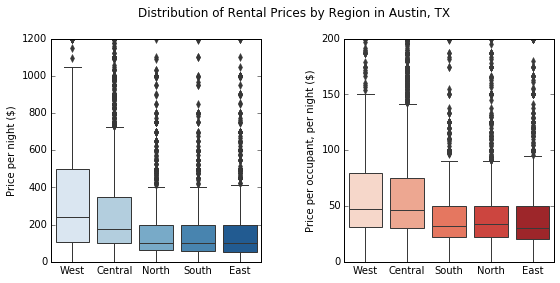

In [96]:
fig, ax = plt.subplots(figsize=(9, 4), ncols=2)

sns.boxplot(x="region", y="price", 
            order=["West", "Central", "North", "South", "East"], 
            ax=ax[0], data=df, palette="Blues")
ax[0].xaxis.label.set_visible(False)
ax[0].set_ylabel("Price per night ($)")
ax[0].set_ylim(0, 1200)
ax[0].tick_params(axis='x', which='both', bottom=False, top=False) 

sns.boxplot(x="region", y="price_per_person", 
            order=["West", "Central", "South", "North", "East"], 
            ax=ax[1], data=df, palette="Reds")
ax[1].xaxis.label.set_visible(False)
ax[1].set_ylabel("Price per occupant, per night ($)")
ax[1].set_ylim(0, 200)
ax[1].tick_params(axis='x', which='both', bottom=False, top=False) 

fig.suptitle("Distribution of Rental Prices by Region in Austin, TX", fontsize=12, y=1.01)
fig.subplots_adjust(wspace=0.4)
fig.savefig('images/boxplot_price_region.png')

### Price based on rental property size

The strongest positive correlation with median price is 'bathrooms', followed by bedroom and accommodates. 

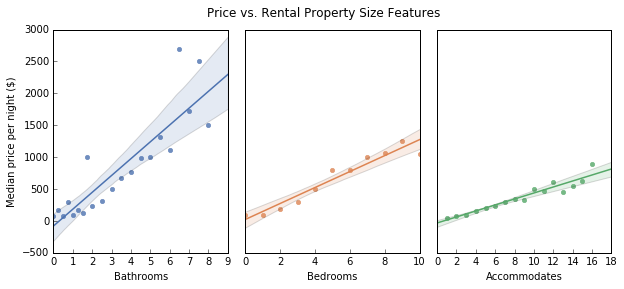

In [78]:
df_grp_bath = df.groupby('bathrooms').price.median().reset_index()
df_grp_bed = df.groupby('bedrooms').price.median().reset_index()
df_grp_acc = df.groupby('accommodates').price.median().reset_index()

fig, ax = plt.subplots(figsize=(10, 4), ncols=3)

sns.regplot(x='bathrooms', y='price', color='#4c72b0',
            data=df_grp_bath, ax=ax[0])
ax[0].set_xlim(0, None)
ax[0].set_xlabel("Bathrooms")
ax[0].set_ylabel("Median price per night ($)")

sns.regplot(x='bedrooms', y='price', color='#dd8452',
            data=df_grp_bed, ax=ax[1])
ax[1].set_xlim(0, 10)
ax[1].set_xlabel("Bedrooms")
ax[1].set_yticks([])
ax[1].yaxis.label.set_visible(False)

sns.regplot(x='accommodates', y='price', color='#55a868',
            data=df_grp_acc, ax=ax[2])
ax[2].set_xlim(0, None)
ax[2].set_xlabel("Accommodates")
ax[2].set_yticks([])
ax[2].yaxis.label.set_visible(False)
 
for a in ax:
    a.set_ylim(-500, 3000)
    a.tick_params(top=False, right=False) 

fig.suptitle("Price vs. Rental Property Size Features", fontsize=12)
fig.subplots_adjust(wspace=0.1)
fig.savefig('images/price_by_property_size.png')

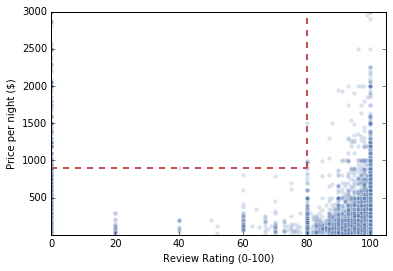

In [38]:
fig, ax = plt.subplots(figsize=(6, 4))
#df_rp = df_rating_price[df_rating_price['price']>1]

#https://stackoverflow.com/questions/38249454/extract-rgb-or-6-digit-code-from-seaborn-palette
sns.scatterplot(x="review_scores_rating", y='price',  
                data=df_rating_price, alpha=0.2, color='#4c72b0')
ax.set_ylim(1, 3000)
ax.set_xlim(0, 105)
ax.set_ylabel("Price per night ($)")
ax.set_xlabel("Review Rating (0-100)")
ax.tick_params(top=False) 
ax.vlines(x=80, ymin=900, ymax=3000, color = '#c44e52', 
          linestyle='--', linewidth=2)
ax.hlines(y=900, xmin=0, xmax=80, color = '#c44e52',
          linestyle='--', linewidth=2)
plt.show();

The price vs rating scatterplot is interesting, but how does the number of reviews factor in?

In [39]:
def f(row):
    if row['number_of_reviews'] == 0:
        val = '0 Reviews'
    elif row['number_of_reviews'] == 1:
        val = '1 Review'
    elif row['number_of_reviews'] == 2:
        val = '2 Reviews'
    else:
        val = '3 or more reviews'
    return val

In [40]:
df_rating_price['reviews_cat'] = df_rating_price.apply(f, axis=1)

In [41]:
df_rating_cat = df_rating_price.groupby('reviews_cat').median().reset_index()

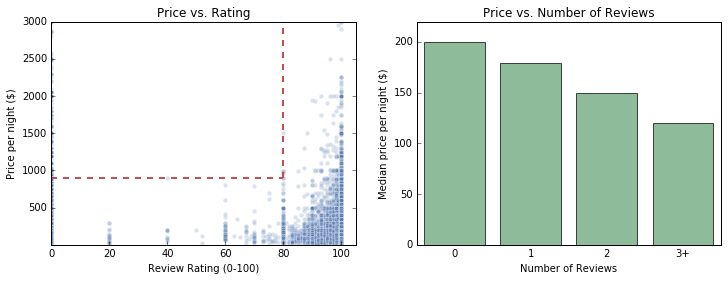

In [49]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)

#https://stackoverflow.com/questions/38249454/extract-rgb-or-6-digit-code-from-seaborn-palette
sns.scatterplot(x="review_scores_rating", y='price',  
                data=df_rating_price, alpha=0.2, ax=ax[0], color='#4c72b0')
ax[0].set_ylim(1, 3000)
ax[0].set_xlim(0, 105)
ax[0].set_ylabel("Price per night ($)")
ax[0].set_xlabel("Review Rating (0-100)")
ax[0].tick_params(top=False) 
ax[0].vlines(x=80, ymin=900, ymax=3000, color = '#c44e52', 
          linestyle='--', linewidth=2)
ax[0].hlines(y=900, xmin=0, xmax=80, color = '#c44e52',
          linestyle='--', linewidth=2)
ax[0].set_title('Price vs. Rating')


ind = range(len(df_rating_cat['price']))
sns.barplot(x=list(ind), y='price', data=df_rating_cat, alpha=0.7,
            color = '#55a868', ax=ax[1])
ax[1].set_ylabel('Median price per night ($)')
ax[1].set_xlabel('Number of Reviews')
ax[1].set_ylim(None, 220)
ax[1].set_xticks(ind)
ax[1].set_xticklabels(['0', '1', '2', '3+'])
ax[1].tick_params(top=False, right=False, bottom=False) 
ax[1].set_title('Price vs. Number of Reviews')

fig.savefig('images/rating_vs_price.png')

***
## Prediction Modeling
I want to look at the features of interest from the analysis section and see if they can tranlate to a 'rough' predition model. 

In [50]:
features_list = ['room_type', 'bathrooms', 'bedrooms', 'accommodates', 
                 'host_is_superhost',  'region', 'review_scores_rating']

# Create features and price DFs for sklearn inputs
features = df[features_list].copy()   # 'X'
price = df['price'].copy()            # 'y'

In [51]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11288 entries, 0 to 11315
Data columns (total 7 columns):
room_type               11288 non-null object
bathrooms               11288 non-null float64
bedrooms                11288 non-null float64
accommodates            11288 non-null int64
host_is_superhost       11288 non-null object
region                  11288 non-null object
review_scores_rating    11288 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 705.5+ KB


In [52]:
# Create dummy variables for 'room type', 'superhost' and 'region'
features = pd.get_dummies(features)
features.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
0,2.0,2.0,4,92.0,1,0,0,0,1,1,0,0,0,0
1,1.0,1.0,2,91.0,0,1,0,0,1,1,0,0,0,0
2,1.0,1.0,3,96.0,1,0,0,1,0,1,0,0,0,0
3,1.0,1.0,2,98.0,0,1,0,0,1,0,0,1,0,0
5,1.0,1.0,3,99.0,1,0,0,0,1,1,0,0,0,0


In [53]:
# Scale the quantitative features
# Note: using RobustScaler and other options resulted in similar r2 results
scaler = MinMaxScaler()
numerical = ['bathrooms', 'bedrooms', 'review_scores_rating', 'accommodates']
features_scaled = features.copy()
features_scaled[numerical] = scaler.fit_transform(features_scaled[numerical])

In [54]:
features_scaled.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
0,0.250,0.2,0.200000,0.9000,1,0,0,0,1,1,0,0,0,0
1,0.125,0.1,0.066667,0.8875,0,1,0,0,1,1,0,0,0,0
2,0.125,0.1,0.133333,0.9500,1,0,0,1,0,1,0,0,0,0
3,0.125,0.1,0.066667,0.9750,0,1,0,0,1,0,0,1,0,0
5,0.125,0.1,0.133333,0.9875,1,0,0,0,1,1,0,0,0,0


In [55]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features_scaled, 
                                                    price, 
                                                    test_size = .20, 
                                                    random_state = 10)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 9030 samples.
Testing set has 2258 samples.


In [56]:
# Models for comparison
models = [SVR(kernel='linear'),
          DecisionTreeRegressor(),
          LinearRegression(),
          KNeighborsRegressor(n_neighbors=7),
          RandomForestRegressor(n_estimators=100)]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]
    results[name] = r2_score(y_test, y_test_preds)

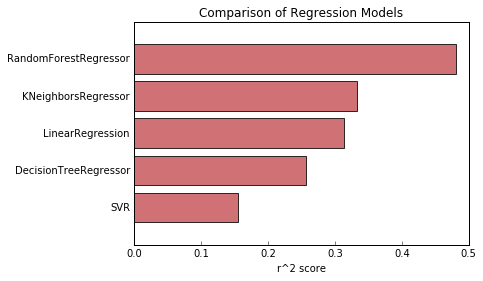

In [59]:
fig, ax = plt.subplots()

ind = range(len(results))
ax.barh(ind, results.values(), align='center', 
        color = '#c44e52', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('r^2 score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
fig.savefig('images/compare_models.png')

In [60]:
# R-square value tells you how much variation is explained by your model
# RandomForestRegressor wins!
reg_model = RandomForestRegressor(n_estimators=100)
reg_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [61]:
X_test.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
9797,0.2500,0.5,0.600000,0.750000,1,0,0,1,0,1,0,0,0,0
4974,0.1250,0.1,0.066667,0.950000,0,1,0,1,0,0,0,0,1,0
748,0.1875,0.1,0.066667,1.000000,0,1,0,0,1,1,0,0,0,0
6062,0.1250,0.1,0.333333,0.952948,1,0,0,1,0,1,0,0,0,0
4294,0.2500,0.3,0.400000,0.887500,1,0,0,1,0,1,0,0,0,0


In [62]:
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

,importance
bathrooms,0.420744
bedrooms,0.173141
accommodates,0.145197
review_scores_rating,0.139385
region_Central,0.031231
region_East,0.017963
host_is_superhost_t,0.015832
host_is_superhost_f,0.015625
region_West,0.015014
room_type_Entire home/apt,0.011180


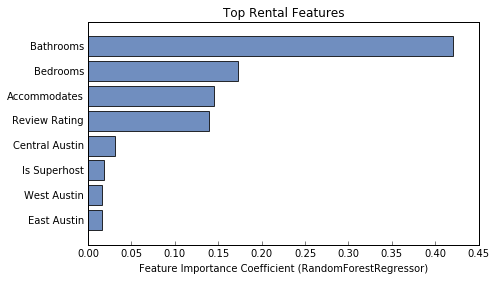

In [75]:
fig, ax = plt.subplots(figsize=(7, 4))

ind = range(0,8)
ax.barh(ind, feature_imp['importance'].values[0:8], 
        align='center', color='#4c72b0', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(['Bathrooms', 'Bedrooms', 'Accommodates', 'Review Rating', \
                    'Central Austin', 'Is Superhost', 'West Austin', 'East Austin'])
ax.set_title("Top Rental Features")
ax.tick_params(left=False, top=False, right=False) 
ax.set_xlabel('Feature Importance Coefficient (RandomForestRegressor)')
plt.gca().invert_yaxis()
fig.savefig('images/feature_importance.png')

Now I'm interested in predicting the prices for the first 

In [64]:
features[:8]

,bathrooms,bedrooms,accommodates,review_scores_rating,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
0,2.0,2.0,4,92.0,1,0,0,0,1,1,0,0,0,0
1,1.0,1.0,2,91.0,0,1,0,0,1,1,0,0,0,0
2,1.0,1.0,3,96.0,1,0,0,1,0,1,0,0,0,0
3,1.0,1.0,2,98.0,0,1,0,0,1,0,0,1,0,0
5,1.0,1.0,3,99.0,1,0,0,0,1,1,0,0,0,0
7,2.0,2.0,5,94.0,1,0,0,1,0,1,0,0,0,0
8,2.0,3.0,6,98.0,1,0,0,1,0,0,0,0,1,0
9,1.0,1.0,2,98.0,0,1,0,0,1,0,1,0,0,0


In [65]:
price_actual = price[:8].values
price_predict = reg_model.predict(features_scaled[:8])
print(price_predict)

[ 187.538       110.32978571  114.55007681   45.06817193  131.2014354
  227.96416667  265.63714286   45.9638448 ]


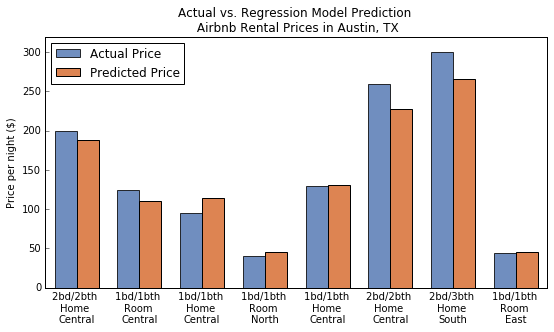

In [73]:
fig, ax = plt.subplots(figsize=(9, 4.5))

# https://matplotlib.org/examples/api/barchart_demo.html
ind = np.arange(0,8)
pad = 0.15
width = 0.35
set_actual = ax.bar(pad+ind, price_actual, width, color='#4c72b0', alpha=0.8)
set_predict = ax.bar(pad+ind+width, price_predict, width, color='#dd8452')

ax.set_ylabel('Price per night ($)')
ax.set_title('Actual vs. Regression Model Prediction \n Airbnb Rental Prices in Austin, TX')
ax.set_xticks(pad + ind + width)
ax.set_ylim(0, 320)
ax.set_xticklabels(['2bd/2bth \nHome \nCentral',
                    '1bd/1bth \nRoom \nCentral',
                   '1bd/1bth \nHome \nCentral',
                   '1bd/1bth \nRoom \nNorth',
                   '1bd/1bth \nHome \nCentral',
                   '2bd/2bth \nHome \nCentral',
                   '2bd/3bth \nHome \nSouth',
                   '1bd/1bth \nRoom \nEast'])
ax.legend( (set_actual, set_predict), ('Actual Price', 'Predicted Price'), 
          loc='upper left')
ax.tick_params(bottom=False, top=False, right=False)

fig.savefig('images/predict_compare.png')